In [2]:
#loading packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import spacy
from collections import Counter
import en_core_web_sm
import re
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from nltk import word_tokenize
from nltk.stem import SnowballStemmer

In [35]:
#loading the dataset
train_df = pd.read_excel('train.xlsx')

In [36]:
#loading the dataset
test_df=pd.read_excel('test.xlsx')

In [37]:
#concatenating the datasets to get the full data set
common_df= pd.concat([train_df, test_df], axis=0)
common_df.shape

(819920, 9)

In [38]:
#resetting the index in the data set
common_df.reset_index(drop=True, inplace=True)

In [39]:
#loading an additional testing sample set out for short text data
short=pd.read_excel('short.xlsx')

In [40]:
#shortening it
short['review_body']=short['review_body'].apply(lambda item: ' '.join(item.split()[:3]))
short.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,fr_0424335,product_fr_0297678,reviewer_fr_0961886,1,A déconseiller -,Brumisateur à pompe,fr,beauty
1,1,fr_0452615,product_fr_0613288,reviewer_fr_0857499,1,Si vous voulez,Insatisfaisant,fr,baby_product
2,2,fr_0407673,product_fr_0571250,reviewer_fr_0383240,1,Écran de mauvaise,Ne recommande pas,fr,pc
3,3,fr_0579191,product_fr_0030168,reviewer_fr_0729693,1,Cet engin ne,A éviter!,fr,musical_instruments
4,4,fr_0931533,product_fr_0468261,reviewer_fr_0734066,1,Très beau produit,Déçue,fr,toy


In [41]:
#removing observations that have zero in the review_body variable
common_df=common_df[common_df['review_body']!=0]

In [42]:
#resetting the index
common_df.reset_index(drop=True, inplace=True)

In [43]:
#removing Unnamed column
common_df = common_df.drop(columns=['Unnamed: 0'])

In [44]:
#converting to lowercase
common_df['review_body']=common_df['review_body'].str.lower()

In [45]:
#removing numbers
common_df['review_body']=common_df['review_body'].str.replace('\d+', '')

In [46]:
#removing URLS
common_df['review_body']=common_df['review_body'].replace(to_replace=r'https?:\/\/.*[\r\n]*',value='',regex=True)

In [47]:
#a list of contractions and the full form
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not","Doesn't":"Does not",
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have", "al": "a el",
                    "del": "de el","puisqu’on":"puisque on","puisqu’il":"puisque il","lorsqu’on":"lorsque on",
                    "lorsqu’il":"lorsque il", "jusqu’à": "jusque à", "jusqu’en":"jusque en", "jusqu’alors":"jusque alors",
                    "jusqu’ici":"jusque ici", "au":"à le","aux":"à les", "auquel":"à lequel","auxquels":"à lesquels",
                    "auxquelles":"à lesquelles","am":"an dem","aufs":"auf das","beim":"bei deim","hinterm":"hinter dem",
                    "durchs":"durch das","fürs":"für das","hinterm":"hinter dem","ins":"in das","im":"in dem","übers":"über das","ums":"um das",
                    "unters":"unter das","unterm":"unter dem","vom":"von dem","vors":"vor das","vorm":"vor dem","zum":"zu dem",
                    "zur":"zu der"}
                       

In [48]:
common_df['review_body']=common_df['review_body'].apply(lambda item: ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in item.split(" ")]))


In [49]:
import unicodedata 
import sys
#removing punctuation
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                           if unicodedata.category(chr(i)).startswith('P'))
common_df['review_body'] = common_df['review_body'].apply(lambda item: ' '.join([string.translate(punctuation) for string in item.split()]))
common_df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,fr_0497116,product_fr_0739436,reviewer_fr_0079605,1,le produit est noté comme livré depuis le juil...,Article non reçu !,fr,home
1,fr_0014704,product_fr_0898711,reviewer_fr_0614903,1,pas terrible ce nai pas comme des faux cils na...,Rien ne vaut les vrais faux cils,fr,beauty
2,fr_0851295,product_fr_0101306,reviewer_fr_0851899,1,je nai jamais reçu le produit,Jamais reçu,fr,home
3,fr_0148716,product_fr_0735028,reviewer_fr_0121344,1,appareil complètement inutile il peigne mais n...,Il ne coupe rien,fr,sports
4,fr_0689615,product_fr_0645938,reviewer_fr_0049041,1,à le bout de utilisations seulement la clé us...,Clé USB inutilisable,fr,pc


In [51]:
#selecting a German subset
common_de=common_df[common_df['language']=='de']
german_stop_words = stopwords.words('german')
common_de['review_body']=common_de['review_body'].apply(lambda item: ' '.join([word for word in item.split() if word not in german_stop_words]))
common_de.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
399958,de_0922014,product_de_0381382,reviewer_de_0983887,1,hahn funktioniert lässt schließen,Hahn lässt sich nicht schließen!,de,home_improvement
399959,de_0892147,product_de_0453891,reviewer_de_0254185,1,dhl express mensch schickt bitte privat per ex...,Versand unzumutbar,de,electronics
399960,de_0372568,product_de_0214043,reviewer_de_0233022,1,sagen nie angekommen immer kulant schnell abge...,Sind NIE angekommen,de,shoes
399961,de_0025479,product_de_0034240,reviewer_de_0860469,1,mal jahr gehalten schade somit weiterempfehlen,Hält nicht lange,de,wireless
399962,de_0163656,product_de_0281122,reviewer_de_0833333,1,ja gerne bewerten irgendwann bekommen,Nicht geliefert,de,automotive


In [52]:
#selecting a French subset
common_fr=common_df[common_df['language']=='fr']
french_stop_words = stopwords.words('french')
common_fr['review_body']=common_fr['review_body'].apply(lambda item: ' '.join([word for word in item.split() if word not in french_stop_words]))

In [53]:
common_fr.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,fr_0497116,product_fr_0739436,reviewer_fr_0079605,1,produit noté comme livré depuis juillet nai ri...,Article non reçu !,fr,home
1,fr_0014704,product_fr_0898711,reviewer_fr_0614903,1,terrible nai comme faux cils naturel mélanger ...,Rien ne vaut les vrais faux cils,fr,beauty
2,fr_0851295,product_fr_0101306,reviewer_fr_0851899,1,nai jamais reçu produit,Jamais reçu,fr,home
3,fr_0148716,product_fr_0735028,reviewer_fr_0121344,1,appareil complètement inutile peigne coupe auc...,Il ne coupe rien,fr,sports
4,fr_0689615,product_fr_0645938,reviewer_fr_0049041,1,bout utilisations seulement clé usb reste coin...,Clé USB inutilisable,fr,pc


In [54]:
#selecting a Spanish subset
common_es=common_df[common_df['language']=='es']
spanish_stop_words = stopwords.words('spanish')
common_es['review_body']=common_es['review_body'].apply(lambda item: ' '.join([word for word in item.split() if word not in spanish_stop_words]))

In [55]:
common_es.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
199978,es_0234773,product_es_0873332,reviewer_es_0138576,1,despues meses escasos uso acabo darme cuenta s...,Despues de 2 meses con apenas uso se esta hund...,es,furniture
199979,es_0379538,product_es_0807931,reviewer_es_0458908,1,roscas si mueves tubo salen solas pierden much...,Material malo,es,pet_products
199980,es_0787870,product_es_0604258,reviewer_es_0077883,1,nunca llego pedido vendedor pasa contestan,No llego nunca,es,sports
199981,es_0533891,product_es_0201015,reviewer_es_0187049,1,desastroso año dejado funcionar completo amazo...,HA DEJADO DE FUNCIONAR,es,electronics
199982,es_0874140,product_es_0643211,reviewer_es_0753747,1,vale linterna dinero tirado basura,Muy descontento,es,home_improvement


In [62]:
#selecting an Englisg subset
common_en=common_df[common_df['language']=='en']
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
common_en['review_body']=common_en['review_body'].apply(lambda item: ' '.join([word for word in item.split() if word not in stop_words]))
common_en.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
599938,en_0402396,product_en_0144253,reviewer_en_0403760,1,problem screen protectors paste well screen di...,"I had problem with the 2 screen protectors, an...",en,wireless
599939,en_0779464,product_en_0925368,reviewer_en_0232341,1,product faulty seller offered refund asked tak...,Not worth $40,en,beauty
599940,en_0210731,product_en_0460656,reviewer_en_0830635,1,bother buying toys didnt even last day,Cheap,en,pet_products
599941,en_0305338,product_en_0202360,reviewer_en_0435908,1,never got item even though said delivered,Never revived item,en,beauty
599942,en_0203840,product_en_0666988,reviewer_en_0390375,1,used much used well loved oxo cookie scoop los...,No Longer a Quality Product,en,kitchen


In [56]:
#loading stemming variables
stemmer_es = SnowballStemmer('spanish')
stemmer_de = SnowballStemmer('german')
stemmer_fr = SnowballStemmer('french')
stemmer_en = SnowballStemmer('english')

In [61]:
common_en.head()

,review_body
599938,"[en_0402396, product_en_0144253, reviewer_en_0..."
599939,"[en_0779464, product_en_0925368, reviewer_en_0..."
599940,"[en_0210731, product_en_0460656, reviewer_en_0..."
599941,"[en_0305338, product_en_0202360, reviewer_en_0..."
599942,"[en_0203840, product_en_0666988, reviewer_en_0..."


In [66]:
#stemming English reviews
common_en['stemmed']= common_en['review_body'].apply(lambda item: ' '.join([stemmer_en.stem(word) for word in item.split()]))
common_en.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stemmed
599938,en_0402396,product_en_0144253,reviewer_en_0403760,1,problem screen protectors paste well screen di...,"I had problem with the 2 screen protectors, an...",en,wireless,problem screen protector past well screen disa...
599939,en_0779464,product_en_0925368,reviewer_en_0232341,1,product faulty seller offered refund asked tak...,Not worth $40,en,beauty,product faulti seller offer refund ask take pr...
599940,en_0210731,product_en_0460656,reviewer_en_0830635,1,bother buying toys didnt even last day,Cheap,en,pet_products,bother buy toy didnt even last day
599941,en_0305338,product_en_0202360,reviewer_en_0435908,1,never got item even though said delivered,Never revived item,en,beauty,never got item even though said deliv
599942,en_0203840,product_en_0666988,reviewer_en_0390375,1,used much used well loved oxo cookie scoop los...,No Longer a Quality Product,en,kitchen,use much use well love oxo cooki scoop lost la...


In [67]:
#stemming German reviews
common_de['stemmed']= common_de['review_body'].apply(lambda item: ' '.join([stemmer_de.stem(word) for word in item.split()]))
common_de.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stemmed
399958,de_0922014,product_de_0381382,reviewer_de_0983887,1,hahn funktioniert lässt schließen,Hahn lässt sich nicht schließen!,de,home_improvement,hahn funktioniert lasst schliess
399959,de_0892147,product_de_0453891,reviewer_de_0254185,1,dhl express mensch schickt bitte privat per ex...,Versand unzumutbar,de,electronics,dhl express mensch schickt bitt privat per exp...
399960,de_0372568,product_de_0214043,reviewer_de_0233022,1,sagen nie angekommen immer kulant schnell abge...,Sind NIE angekommen,de,shoes,sag nie angekomm imm kulant schnell abgewickelt
399961,de_0025479,product_de_0034240,reviewer_de_0860469,1,mal jahr gehalten schade somit weiterempfehlen,Hält nicht lange,de,wireless,mal jahr gehalt schad somit weiterempfehl
399962,de_0163656,product_de_0281122,reviewer_de_0833333,1,ja gerne bewerten irgendwann bekommen,Nicht geliefert,de,automotive,ja gern bewert irgendwann bekomm


In [68]:
#stemming Spanish reviews
common_es['stemmed']= common_es['review_body'].apply(lambda item: ' '.join([stemmer_es.stem(word) for word in item.split()]))
common_es.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stemmed
199978,es_0234773,product_es_0873332,reviewer_es_0138576,1,despues meses escasos uso acabo darme cuenta s...,Despues de 2 meses con apenas uso se esta hund...,es,furniture,despu mes escas uso acab darm cuent soport cen...
199979,es_0379538,product_es_0807931,reviewer_es_0458908,1,roscas si mueves tubo salen solas pierden much...,Material malo,es,pet_products,rosc si muev tub sal sol pierd much agu
199980,es_0787870,product_es_0604258,reviewer_es_0077883,1,nunca llego pedido vendedor pasa contestan,No llego nunca,es,sports,nunc lleg ped vendedor pas contest
199981,es_0533891,product_es_0201015,reviewer_es_0187049,1,desastroso año dejado funcionar completo amazo...,HA DEJADO DE FUNCIONAR,es,electronics,desastr año dej funcion complet amazon da opci...
199982,es_0874140,product_es_0643211,reviewer_es_0753747,1,vale linterna dinero tirado basura,Muy descontento,es,home_improvement,val lintern diner tir basur


In [69]:
#stemming French reviews
common_fr['stemmed']= common_fr['review_body'].apply(lambda item: ' '.join([stemmer_fr.stem(word) for word in item.split()]))
common_fr.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stemmed
0,fr_0497116,product_fr_0739436,reviewer_fr_0079605,1,produit noté comme livré depuis juillet nai ri...,Article non reçu !,fr,home,produit not comm livr depuis juillet nai rien ...
1,fr_0014704,product_fr_0898711,reviewer_fr_0614903,1,terrible nai comme faux cils naturel mélanger ...,Rien ne vaut les vrais faux cils,fr,beauty,terribl nai comm faux cil naturel mélang a lou...
2,fr_0851295,product_fr_0101306,reviewer_fr_0851899,1,nai jamais reçu produit,Jamais reçu,fr,home,nai jam reçu produit
3,fr_0148716,product_fr_0735028,reviewer_fr_0121344,1,appareil complètement inutile peigne coupe auc...,Il ne coupe rien,fr,sports,appareil complet inutil peign coup aucun poil ...
4,fr_0689615,product_fr_0645938,reviewer_fr_0049041,1,bout utilisations seulement clé usb reste coin...,Clé USB inutilisable,fr,pc,bout utilis seul clé usb rest coinc port usb n...


In [70]:
#join the data together
common_df_stemmed= pd.concat([common_fr, common_de,common_es,common_en], axis=0)
common_df_stemmed.reset_index(drop=True, inplace=True)
common_df_stemmed.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stemmed
0,fr_0497116,product_fr_0739436,reviewer_fr_0079605,1,produit noté comme livré depuis juillet nai ri...,Article non reçu !,fr,home,produit not comm livr depuis juillet nai rien ...
1,fr_0014704,product_fr_0898711,reviewer_fr_0614903,1,terrible nai comme faux cils naturel mélanger ...,Rien ne vaut les vrais faux cils,fr,beauty,terribl nai comm faux cil naturel mélang a lou...
2,fr_0851295,product_fr_0101306,reviewer_fr_0851899,1,nai jamais reçu produit,Jamais reçu,fr,home,nai jam reçu produit
3,fr_0148716,product_fr_0735028,reviewer_fr_0121344,1,appareil complètement inutile peigne coupe auc...,Il ne coupe rien,fr,sports,appareil complet inutil peign coup aucun poil ...
4,fr_0689615,product_fr_0645938,reviewer_fr_0049041,1,bout utilisations seulement clé usb reste coin...,Clé USB inutilisable,fr,pc,bout utilis seul clé usb rest coinc port usb n...


In [71]:
#saving it toan xlsx file
common_df_stemmed.to_excel('stemmed.xlsx')

In [72]:
common_df_stemmed.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stemmed
0,fr_0497116,product_fr_0739436,reviewer_fr_0079605,1,produit noté comme livré depuis juillet nai ri...,Article non reçu !,fr,home,produit not comm livr depuis juillet nai rien ...
1,fr_0014704,product_fr_0898711,reviewer_fr_0614903,1,terrible nai comme faux cils naturel mélanger ...,Rien ne vaut les vrais faux cils,fr,beauty,terribl nai comm faux cil naturel mélang a lou...
2,fr_0851295,product_fr_0101306,reviewer_fr_0851899,1,nai jamais reçu produit,Jamais reçu,fr,home,nai jam reçu produit
3,fr_0148716,product_fr_0735028,reviewer_fr_0121344,1,appareil complètement inutile peigne coupe auc...,Il ne coupe rien,fr,sports,appareil complet inutil peign coup aucun poil ...
4,fr_0689615,product_fr_0645938,reviewer_fr_0049041,1,bout utilisations seulement clé usb reste coin...,Clé USB inutilisable,fr,pc,bout utilis seul clé usb rest coinc port usb n...


In [73]:
#creating Logistic Regression Pipeline
from sklearn.pipeline import Pipeline
tvec = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
lr = LogisticRegression()
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

In [74]:
common_df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,fr_0497116,product_fr_0739436,reviewer_fr_0079605,1,le produit est noté comme livré depuis le juil...,Article non reçu !,fr,home
1,fr_0014704,product_fr_0898711,reviewer_fr_0614903,1,pas terrible ce nai pas comme des faux cils na...,Rien ne vaut les vrais faux cils,fr,beauty
2,fr_0851295,product_fr_0101306,reviewer_fr_0851899,1,je nai jamais reçu le produit,Jamais reçu,fr,home
3,fr_0148716,product_fr_0735028,reviewer_fr_0121344,1,appareil complètement inutile il peigne mais n...,Il ne coupe rien,fr,sports
4,fr_0689615,product_fr_0645938,reviewer_fr_0049041,1,à le bout de utilisations seulement la clé us...,Clé USB inutilisable,fr,pc


In [75]:
def lr_cv(splits, X, Y, pipeline, average_method, testing):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        model_result=lr_fit.predict(testing)
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              de          en          es       fr')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*56)

    print("accuracy: %.3f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.3f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.3f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.3f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    return(model_result)

In [76]:
%%time
#checking the performance of the original imbalanced data set for logistic regression model
lr_cv(5, common_df_stemmed.stemmed, common_df_stemmed.language, original_pipeline,'macro', short.review_body)

              de          en          es       fr
precision: [0.9979054  0.99897518 0.99868235 0.99899905]
recall:    [0.99941458 0.99865841 0.9983413  0.99814616]
f1 score:  [0.99865942 0.99881677 0.9985118  0.99857242]
--------------------------------------------------------
              de          en          es       fr
precision: [0.99744438 0.99899946 0.99839028 0.9993646 ]
recall:    [0.99963411 0.99856084 0.99851205 0.99748756]
f1 score:  [0.99853805 0.9987801  0.99845116 0.9984252 ]
--------------------------------------------------------
              de          en          es       fr
precision: [0.9976619  0.99882841 0.99809802 0.9988277 ]
recall:    [0.99919504 0.99819495 0.99843887 0.99758513]
f1 score:  [0.99842788 0.99851158 0.99826842 0.99820603]
--------------------------------------------------------
              de          en          es       fr
precision: [0.99778389 0.99890155 0.99814688 0.99899856]
recall:    [0.99941458 0.99819495 0.99853644 0.99768264]
f1

array(['de', 'es', 'fr', 'fr', 'fr', 'fr', 'de', 'de', 'de', 'es', 'fr',
       'fr', 'de', 'de', 'de', 'de', 'fr', 'fr', 'fr', 'de', 'es', 'de',
       'de', 'de', 'de', 'de', 'es', 'de', 'es', 'de', 'es', 'de', 'es',
       'de', 'de', 'es', 'de', 'es', 'de', 'de', 'de', 'de', 'de', 'es',
       'de', 'de', 'es', 'de', 'en', 'de', 'es', 'de', 'de', 'es', 'es',
       'de', 'de', 'es', 'de', 'en', 'en', 'de', 'de', 'es', 'en', 'en',
       'de', 'de', 'de', 'en', 'de', 'en', 'es', 'de', 'de', 'es', 'en',
       'en', 'en', 'en'], dtype=object)

In [77]:
#creating Multinomial Naive Bayes Pipeline
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
bayes_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', clf)
])

In [78]:
%%time
lr_cv(5, common_df_stemmed.stemmed, common_df_stemmed.language,  bayes_pipeline,'macro',short.review_body)

              de          en          es       fr
precision: [0.99822151 0.99899988 0.99875513 0.99875534]
recall:    [0.99943897 0.99897551 0.99807298 0.99824373]
f1 score:  [0.99882987 0.99898769 0.99841394 0.99849947]
--------------------------------------------------------
              de          en          es       fr
precision: [0.99785716 0.99904862 0.99870684 0.99909622]
recall:    [0.99958533 0.99897551 0.99843887 0.99770709]
f1 score:  [0.9987205  0.99901206 0.99857284 0.99840117]
--------------------------------------------------------
              de          en          es       fr
precision: [0.99807538 0.99890201 0.9985114  0.9985845 ]
recall:    [0.99931701 0.99860962 0.99807298 0.99807298]
f1 score:  [0.99869581 0.99875579 0.99829214 0.99832868]
--------------------------------------------------------
              de          en          es       fr
precision: [0.99814851 0.99890206 0.99851198 0.99890123]
recall:    [0.99941458 0.99865841 0.99846326 0.99792658]
f1

array(['de', 'es', 'fr', 'fr', 'fr', 'fr', 'de', 'de', 'de', 'es', 'fr',
       'fr', 'de', 'de', 'de', 'de', 'fr', 'fr', 'fr', 'de', 'es', 'es',
       'es', 'de', 'de', 'de', 'es', 'de', 'es', 'de', 'es', 'de', 'es',
       'de', 'de', 'es', 'de', 'es', 'de', 'de', 'de', 'es', 'de', 'es',
       'de', 'de', 'es', 'de', 'en', 'de', 'es', 'de', 'de', 'es', 'es',
       'de', 'de', 'es', 'de', 'en', 'en', 'en', 'fr', 'de', 'en', 'en',
       'de', 'de', 'de', 'en', 'de', 'en', 'es', 'de', 'de', 'es', 'en',
       'en', 'en', 'en'], dtype='<U2')

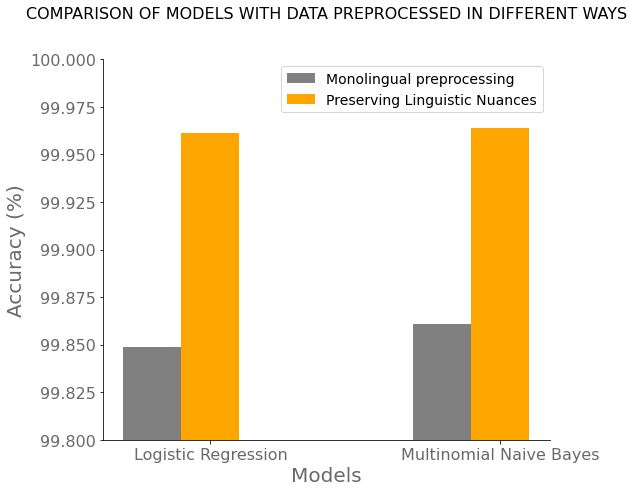

In [1]:
#creating a grouped bar graph to compare the performance of the same models using different preprocessing techniques
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (8,7)
# create data
x = np.arange(2)
y1 = [99.849, 99.861]
y2 = [99.961, 99.964]

width = 0.2
fig, ax = plt.subplots()
 
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='gray')
plt.bar(x, y2, width, color='orange')
plt.ylim(99.80,100)

#customizing x label
plt.xlabel('Models', fontsize=20, color='dimgrey')
#customizing y label
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)
plt.yticks(fontsize=16, color='dimgrey')
plt.xticks(fontsize=16, color='dimgrey')
plt.ylabel('Accuracy (%)', fontsize=20,color= 'dimgrey');
plt.xticks(x, ['Logistic Regression', 'Multinomial Naive Bayes'])
plt.legend(['Monolingual preprocessing','Preserving Linguistic Nuances'], fontsize=14)
plt.title('COMPARISON OF MODELS WITH DATA PREPROCESSED IN DIFFERENT WAYS\n\n', fontsize=16)
plt.show()